In [5]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix


DB = '../data/checking-logs.sqlite'
data_path = '../data/ab-test.csv'

conn = sqlite3.connect(DB)




In [6]:
query = """
SELECT 
    test.uid,
    AVG((julianday(test.first_commit_ts) - julianday(deadlines.deadlines, 'unixepoch')) * 24) AS avg_diff,
    pageviews.pageviews
FROM (
    SELECT 
        uid, 
        labname, 
        MIN(first_commit_ts) AS first_commit_ts
    FROM test
    WHERE labname != 'project1'
    GROUP BY uid, labname
) AS test
JOIN deadlines ON test.labname = deadlines.labs
JOIN (
    SELECT 
        uid, 
        COUNT(*) AS pageviews
    FROM pageviews
    GROUP BY uid
) AS pageviews ON test.uid = pageviews.uid
GROUP BY test.uid



"""
num_c = pd.read_sql_query("SELECT uid, COUNT(timestamp) as num_commits FROM checker WHERE uid like 'user_%' AND labname NOT like 'project1' GROUP BY uid", conn)
views_diff = pd.read_sql(query, conn)
conn.close()
views_diff


,uid,avg_diff,pageviews
0,user_1,-65.119644,28
1,user_10,-75.242310,89
2,user_14,-159.568696,143
3,user_17,-62.207513,47
4,user_18,-6.367907,3
5,user_19,-99.440298,16
6,user_21,-96.111041,10
7,user_25,-93.474751,179
8,user_28,-86.793652,149
9,user_3,-105.738041,317


In [7]:
all = pd.merge(views_diff,num_c, on='uid',how='inner')
all

,uid,avg_diff,pageviews,num_commits
0,user_1,-65.119644,28,62
1,user_10,-75.242310,89,20
2,user_14,-159.568696,143,61
3,user_17,-62.207513,47,51
4,user_18,-6.367907,3,5
5,user_19,-99.440298,16,118
6,user_21,-96.111041,10,65
7,user_25,-93.474751,179,79
8,user_28,-86.793652,149,60
9,user_3,-105.738041,317,18


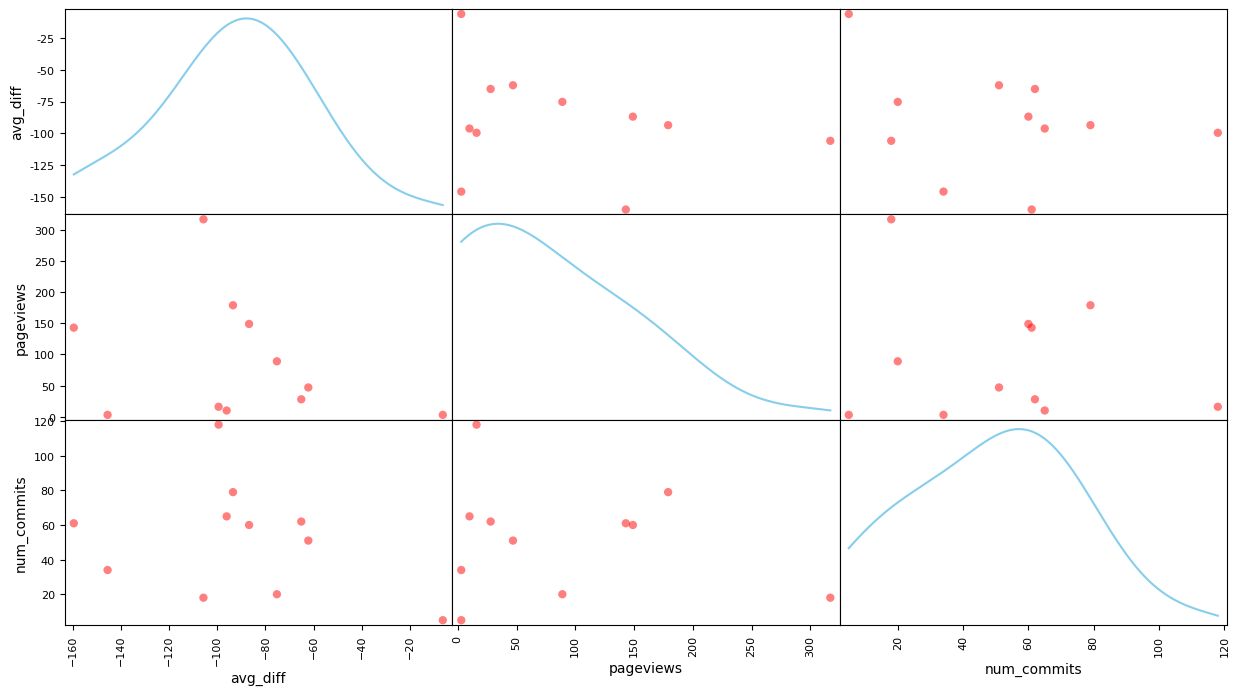

In [8]:
axes = scatter_matrix(all, figsize=(15, 8), diagonal='kde', marker='o', color='red', linewidths=3, hist_kwds={'linewidth': 3})

for i in range(len(all.columns) - 1):
    ax = axes[i, i]
    for line in ax.lines:
        line.set_color('skyblue')


Can we say that if a user has a low number of pageviews then they likely have a low number of commits?

The answer: no

Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?

The answer: no.

Can we say that there are many users with a low number of commits and a few with a high number of commits? 

The answer: yes.

Can we say that there are many users with a small average difference and a few with a large average difference? 

The answer: no.